In [78]:
import os
import gc
import sys
import importlib as imp
import numpy as np
import pandas as pd
from tqdm import tqdm, tqdm_notebook
sys.path.append('..')

# 1. Data Loading

In [8]:
NAME = 'ohsumed'
X_train_df = pd.read_csv('../data/%s/clean/%s_train.csv' % (NAME, NAME))
X_train_df = X_train_df[X_train_df.columns[-4:]]
X_test_df = pd.read_csv('../data/%s/clean/%s_test.csv' % (NAME, NAME))
X_test_df = X_test_df[X_test_df.columns[-4:]]

# 2. Data preprocessing

## 2.1 Preprocess text 
```already DONE```

In [25]:
import preprocess.text as ptext
ptext = imp.reload(ptext)

text_preprocessor = ptext.CorpusProcessor()

# X_train_df = text_preprocessor.preprocess(df=X_train_df)
# X_test_df = text_preprocessor.preprocess(df=X_test_df)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vadik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vadik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [65]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')

X_train_df['tokens'] = X_train_df['clean_text'].apply(lambda x: word_tokenize(x))
X_test_df['tokens'] = X_test_df['clean_text'].apply(lambda x: word_tokenize(x))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vadik\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 2.2. Build vocab

In [112]:
import preprocess.utils as putils
putils = imp.reload(putils)

MIN_TF = 15
MAX_TF = 500
MASTER_NODE = False


vocab_terms, term2id = putils.build_vocab(X_train_df['clean_text'], 
                                          min_tf=MIN_TF, 
                                          max_tf=MAX_TF,
                                          master_node=MASTER_NODE)

print('VOCAB SIZE:', len(vocab_terms))


VOCAB SIZE: 3236


In [109]:
# term2id

## 2.2. Build text-network

In [39]:
import networkx as nx
import preprocess.graph as pgraph
pgraph = imp.reload(pgraph)

In [57]:
sample_text = X_train_df['clean_text'].iloc[10].split()[:20]
print(' '.join(sample_text))

treatment oral candidosis itraconazole review oral candidosis common infection infant elderly person patient receive immunosuppressive therapy patient acquire immunodeficiency syndrome


In [61]:
win_size = 3
max_nds = 9

G_sample = pgraph.doc2graph(sample_text, 
                            max_nodes=max_nds, 
                            window_size=win_size, 
                            infranodus_weights=True, 
                            is_directed=True)

In [62]:
A = nx.adjacency_matrix(G_sample).todense()
np.fill_diagonal(A, 1)
pd.DataFrame(np.around(A, 1), columns=G_sample.nodes, index=G_sample.nodes)

,treatment,oral,candidosis,itraconazole,review,common,infection,infant,elderly
treatment,1,3,2,1,0,0,0,0,0
oral,0,1,3,2,1,2,1,0,0
candidosis,0,1,1,3,2,3,2,1,0
itraconazole,0,2,1,1,3,0,0,0,0
review,0,3,2,0,1,1,0,0,0
common,0,0,0,0,0,1,3,2,1
infection,0,0,0,0,0,0,1,0,0
infant,0,0,0,0,0,0,0,1,0
elderly,0,0,0,0,0,0,0,0,1


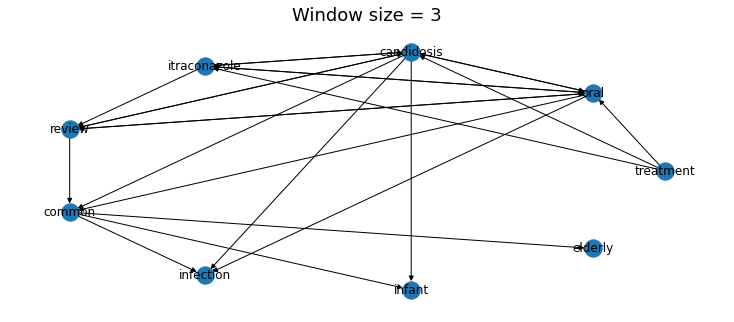

In [63]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 4))
pos = nx.circular_layout(G_sample)
nx.draw(G_sample, with_labels=True, pos=pos)
plt.title('Window size = %d' % win_size, fontsize=18)
pass

# 3. Prepare & Train

In [76]:
putils = imp.reload(putils)


MAX_NODES = putils.get_max_nodes(X_train_df, quantile=0.95, master_node=MASTER_NODE)
print('MAX NODES:', MAX_NODES)

MAX NODES: 108


In [134]:
import preprocess.general as pgeneral
pgeneral = imp.reload(pgeneral)



WINDOW_SIZE = 3

try:
    del X_adj_test
    del X_adj_train
    del X_emb_test
    del X_emb_train
except:
    pass


X_adj_train, X_emb_train, Y_train = pgeneral.get_dataset_from_df(X_train_df, 
                                                                 MAX_NODES,  
                                                                 window_size=WINDOW_SIZE,
                                                                 term2id=term2id,
                                                                    # pmi_matrix=pmi_matrix
                                                                    )

gc.collect()
# X_adj_test, X_emb_test, Y_test = pgeneral.get_dataset_from_df(X_test_df, 
#                                                               MAX_NODES,  
#                                                               window_size=WINDOW_SIZE,
#                                                               term2id=term2id,
#                                                             # pmi_matrix=pmi_matrix
#                                                             ) 
# gc.collect()

3

In [135]:
X_emb_train

array([[   0,    1,    2, ..., 3235, 3235, 3235],
       [  38,   39,    3, ..., 3235, 3235, 3235],
       [  98,   99,  100, ..., 3235, 3235, 3235],
       ...,
       [2760, 2681, 1948, ..., 3235, 3235, 3235],
       [ 283,  647,  913, ..., 3235, 3235, 3235],
       [3061, 1185,  193, ..., 3235, 3235, 3235]])

In [ ]:
from spektral.transforms import GCNFilter, AdjToSpTensor
pgeneral = imp.reload(pgeneral)

train_spektral = pgeneral.CustomDataset(X_emb_train, 
                                        X_adj_train, 
                                        Y_train, 
                                        transforms=[GCNFilter()]) #,  AdjToSpTensor()])
gc.collect()
test_spektral = pgeneral.CustomDataset(X_emb_test, 
                                       X_adj_test, 
                                       Y_test,  
                                       transforms=[GCNFilter()])#,  AdjToSpTensor()])
gc.collect()